## E-Commerce Recommendation System

### Step 0: Load Packages and Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity  #for checking similarity between two words
from sklearn.feature_extraction.text import TfidfVectorizer  #for converting text to vector

import os
from scipy.sparse import coo_matrix

### Step 1: Data Loading and Preprocessing

In [6]:
# Read your dataset as iam taking walmart product review dataset here
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')


In [7]:
train_data.shape

(5000, 32)

In [8]:
train_data.head()

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Currency,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN,NaN,NaN,81350af1be98d3753cf964709f0c766a
1,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN,NaN,NaN,0353e63907dc0de0c734db4690300057
2,8d4d0330178d3ed181b15a4102b287f2,2020-08-06 05:51:47 +0000,NaN,8a4fe5d9c7a6ed26cc44d785a454b124,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,NaN,Clairol Nice 'N Easy Permanent Color 7/106A Na...,NaN,4.5,29221.0,NaN,b6985c8e94815fbca2319dbb8bf228af
3,fddc4df45b35efd886794b261f730c51,2020-07-15 11:22:04 +0000,NaN,03b5fb878a33eadff8b033419eab9669,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/25b4b467-bc61...,NaN,"Kokie Professional Matte Lipstick, Hot Berry, ...",NaN,NaN,NaN,NaN,85b70fded09186f00467cea2f935b779
4,0990cf89a59ca6a0460349a3e4f51d42,2020-11-26T12:27:20+00:00,NaN,ce3d761e57d6ccad80619297b5b1bcbc,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,NaN,"Gillette TRAC II Plus Razor Blade Refills, Fit...",NaN,NaN,131.0,NaN,41c870871328e97da6fb036bb7d4b2da


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Uniq Id                          5000 non-null   object 
 1   Crawl Timestamp                  5000 non-null   object 
 2   Dataset Origin                   0 non-null      float64
 3   Product Id                       5000 non-null   object 
 4   Product Barcode                  0 non-null      float64
 5   Product Company Type Source      5000 non-null   object 
 6   Product Brand Source             139 non-null    object 
 7   Product Brand Normalised Source  139 non-null    object 
 8   Product Name Source              139 non-null    object 
 9   Match Rank                       0 non-null      float64
 10  Match Score                      0 non-null      float64
 11  Match Type                       0 non-null      float64
 12  Retailer            

In [10]:
train_data.isnull().sum()

Uniq Id                               0
Crawl Timestamp                       0
Dataset Origin                     5000
Product Id                            0
Product Barcode                    5000
Product Company Type Source           0
Product Brand Source               4861
Product Brand Normalised Source    4861
Product Name Source                4861
Match Rank                         5000
Match Score                        5000
Match Type                         5000
Retailer                              0
Product Category                     10
Product Brand                        13
Product Name                          0
Product Price                        42
Sku                                5000
Upc                                5000
Product Url                           0
Market                                0
Product Description                1127
Product Currency                      0
Product Available Inventory           0
Product Image Url                     0


### taking most important columns only from dataset which we need for our model

In [12]:

train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [13]:
train_data.info()   #only these indep features we need for our model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Uniq Id                5000 non-null   object 
 1   Product Id             5000 non-null   object 
 2   Product Rating         2194 non-null   float64
 3   Product Reviews Count  3346 non-null   float64
 4   Product Category       4990 non-null   object 
 5   Product Brand          4987 non-null   object 
 6   Product Name           5000 non-null   object 
 7   Product Image Url      5000 non-null   object 
 8   Product Description    3873 non-null   object 
 9   Product Tags           5000 non-null   object 
dtypes: float64(2), object(8)
memory usage: 390.8+ KB


In [14]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

### Handling missing/NaN values in data

In [16]:
#numerical features 
train_data['Product Rating'] =train_data['Product Rating'].fillna(0)  #it will replace NaN value with 0 value
train_data['Product Reviews Count'] =train_data['Product Reviews Count'].fillna(0)  #it will replace NaN value with 0 value

In [17]:
#categorical features
train_data['Product Category'] =train_data['Product Category'].fillna('')  #it will replace NaN value with 0 value
train_data['Product Brand'] =train_data['Product Brand'].fillna(0)  #it will replace NaN value with 0 value
train_data['Product Description'] =train_data['Product Description'].fillna(0)  #it will replace NaN value with 0 value

In [18]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [19]:
train_data['Product Rating'].value_counts()

Product Rating
0.0    2806
5.0     453
4.6     192
4.5     176
4.4     162
4.0     138
4.7     138
4.8     134
4.3     131
4.2     124
3.0      65
4.1      62
4.9      53
3.9      48
3.7      46
3.8      46
1.0      45
3.5      43
3.6      30
3.3      19
2.0      18
3.4      14
3.2      10
2.7       7
3.1       7
2.3       6
2.9       5
2.6       4
2.4       4
2.5       3
2.2       3
2.8       2
1.5       2
1.8       2
2.1       1
1.3       1
Name: count, dtype: int64

In [20]:
train_data.duplicated().sum()  #duplicated() helps in identifying duplicate rows, which is useful for cleaning data, especially when handling redundancy.

0

as there is no duplicate rows available in all the 5000 rows ,all rows are unique and have no NaN values 

### Rename the names of the columns to look more better

In [23]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True) 

In [24]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           5000 non-null   object 
 1   ProdID       5000 non-null   object 
 2   Rating       5000 non-null   float64
 3   ReviewCount  5000 non-null   float64
 4   Category     5000 non-null   object 
 5   Brand        5000 non-null   object 
 6   Name         5000 non-null   object 
 7   ImageURL     5000 non-null   object 
 8   Description  5000 non-null   object 
 9   Tags         5000 non-null   object 
dtypes: float64(2), object(8)
memory usage: 390.8+ KB


In [25]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


### Handling Categorical features 

In [27]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

#Using str.extract() with (\d+) will only capture the first group of digits and \d matches any digit (0-9)

In [28]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


## Step 2: EDA 

In [30]:
# Basic statistics and Data Analysis
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


In [31]:
train_data.shape

(5000, 10)

In [32]:
#The pivot_table() function is essential for data analysis in pandas, enabling you to summarize and aggregate data effectively. 
#It allows for greater flexibility compared to the basic pivot() method, particularly when dealing with duplicate data and needing aggregation.

In [33]:
 #Pivot the DataFrame to create a heatmap means  reshaping the data so that you can reorganize it based on one or more columns.
heatmap_data = train_data.pivot_table(values='ID', index='Rating')  #taking unique ratings only
heatmap_data

,ID
Rating,
0.0,2.903881e+20
1.0,4.810669e+05
1.3,8.000000e+00
1.5,3.315000e+02
1.8,3.517850e+04
2.0,1.834903e+06
2.1,7.099400e+05
2.2,4.666667e+00
2.3,5.533333e+02


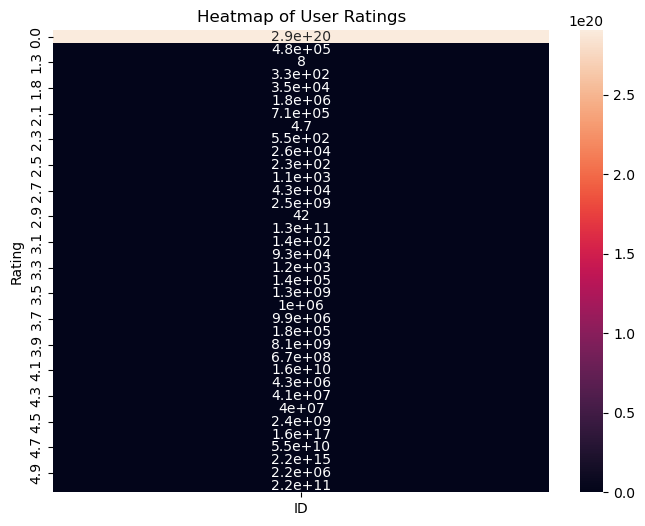

In [34]:
#visz. of heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data,annot=True )

plt.title('Heatmap of User Ratings')
plt.show()

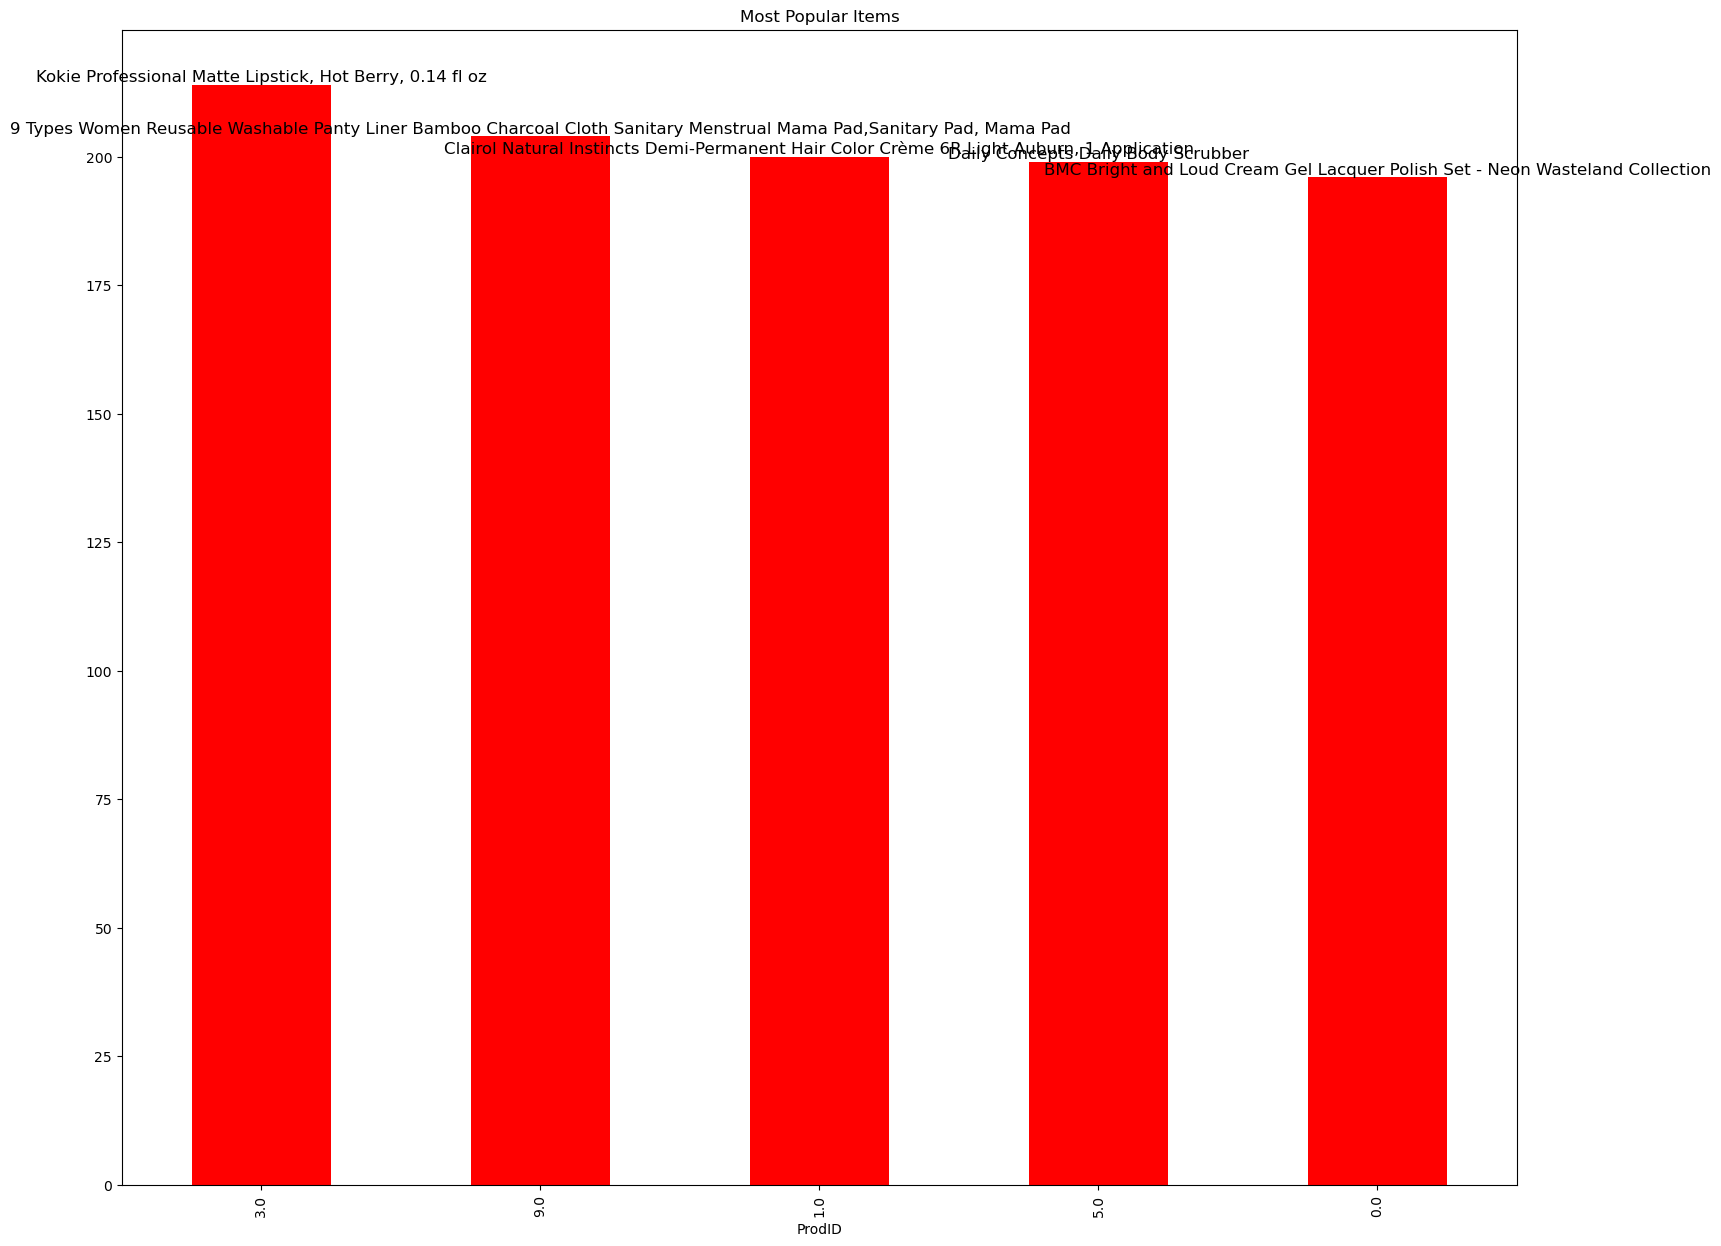

In [35]:
plt.figure(figsize=(18, 15))

# 5 Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)

# Get unique names for the ProdID values
names = train_data.drop_duplicates(subset='ProdID').set_index('ProdID')['Name']

# Plot the bar chart
ax = popular_items.plot(kind='bar', color='red')

# Add the title
plt.title("Most Popular Items")

# Add product name labels on top of each bar
for i, val in enumerate(popular_items):
    ax.text(i, val, names[popular_items.index[i]], ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

<Axes: xlabel='Rating'>

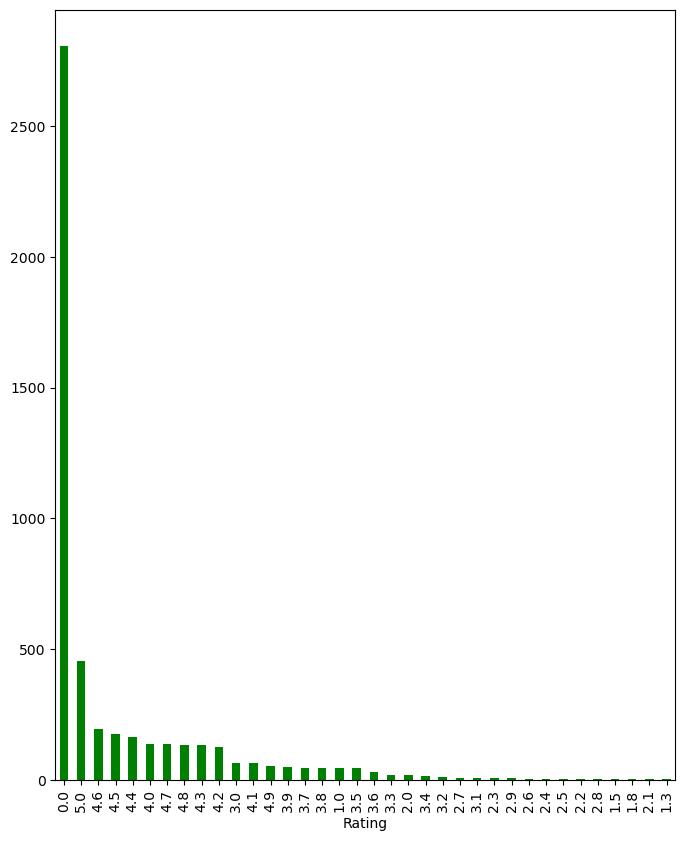

In [36]:
plt.figure(figsize=(8, 10))

# Most Rated Counts
popular_items = train_data['Rating'].value_counts()
popular_items.plot(kind='bar',color='green')

In [37]:
train_data['Rating'].value_counts()

Rating
0.0    2806
5.0     453
4.6     192
4.5     176
4.4     162
4.0     138
4.7     138
4.8     134
4.3     131
4.2     124
3.0      65
4.1      62
4.9      53
3.9      48
3.7      46
3.8      46
1.0      45
3.5      43
3.6      30
3.3      19
2.0      18
3.4      14
3.2      10
2.7       7
3.1       7
2.3       6
2.9       5
2.6       4
2.4       4
2.5       3
2.2       3
2.8       2
1.5       2
1.8       2
2.1       1
1.3       1
Name: count, dtype: int64

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           5000 non-null   float64
 1   ProdID       5000 non-null   float64
 2   Rating       5000 non-null   float64
 3   ReviewCount  5000 non-null   float64
 4   Category     5000 non-null   object 
 5   Brand        5000 non-null   object 
 6   Name         5000 non-null   object 
 7   ImageURL     5000 non-null   object 
 8   Description  5000 non-null   object 
 9   Tags         5000 non-null   object 
dtypes: float64(4), object(6)
memory usage: 390.8+ KB


### Step 3: Data Cleaning and Tags Creations

In [40]:
train_data.head(5)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [41]:
#!python -m spacy download en_core_web_sm
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    # Check if the text is a string
    if isinstance(text, str):
        doc = nlp(text.lower())
        tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
        return ', '.join(tags)  #joining with ,
    else:
        # Return an empty string or handle non-string cases
        return ''

# Assuming train_data is your DataFrame and columns_to_extract_tags_from is defined
columns_to_extract_tags_from = ['Category', 'Brand', 'Description']
for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

#nlp = spacy.load("en_core_web_sm") is used to load a pre-trained English language model from the spaCy library. This model is used for various Natural Language Processing (NLP) tasks like tokenization, part-of-speech tagging, named entity recognition, lemmatization, and more.


In [42]:
train_data.head(5)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...",Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [43]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [44]:
train_data.head(5)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."
3,4.000000e+00,3.0,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","beauty, makeup, lip, kokie, cosmetics, calling..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","seasonal, stock, essentials, personal, care, s..."


In [45]:
train_data['Tags'][0]  #it concatenates the category value and Brand value together and made a single tag value at last

'premium, beauty, premium, makeup, premium, nail, polish, care, premium, nail, polish, opi, '

### Rating Based Recommendation 

In [47]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()
average_ratings

,Name,ReviewCount,Brand,ImageURL,Rating
0,$6 Mail-In Rebate Available Braun Epilator Sil...,146.0,braun,https://i5.walmartimages.com/asr/c7d78838-e8e2...,4.5
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
2,($11 Value) Love Beauty and Planet Coconut Wat...,278.0,"love, beauty, planet",https://i5.walmartimages.com/asr/0348d82d-2a13...,0.0
3,($125 Value) Impressions Vanity Touch Pro LED ...,2.0,"impressions, vanity",https://i5.walmartimages.com/asr/b886b154-97fd...,2.5
4,($129 Value) CHI G2 Ceramic Titanium Infused H...,23.0,chi,https://i5.walmartimages.com/asr/9bcc0ed7-d62c...,4.4
...,...,...,...,...,...
4987,"wet n wild Photo Focus Correcting Palette, Col...",12.0,"wet, n, wild",https://i5.walmartimages.com/asr/750275fb-ccfa...,3.3
4988,"wet n wild Photo Focus Liquid Foundation, Medi...",7827.0,"wet, n, wild",https://i5.walmartimages.com/asr/c2c5dc7e-9bbb...,0.0
4989,"wet n wild Photo Focus Pressed Powder, Dark Café",635.0,"wet, n, wild",https://i5.walmartimages.com/asr/57bd497f-0d5c...,4.2
4990,"wet n wild Silk Finish Lipstick, Honolulu Is C...",4259.0,"wet, n, wild",https://i5.walmartimages.com/asr/0e25f705-a924...,3.9


In [48]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)  #taking only top 10 rated items only for recommendation to users

In [49]:
rating_base_recommendation  #getting only top 10 products to show

,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4.0,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5.0
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2.0,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5.0
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2.0,"gold, bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5.0
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24.0,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5.0
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2.0,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5.0
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1.0,"red, devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5.0
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1.0,"air, wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5.0
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4.0,"bain, de, terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5.0
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12.0,"long, aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5.0
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1.0,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5.0


In [50]:
#changing datatypes

rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

C:\Users\subham.mehta\AppData\Local\Temp\ipykernel_22788\1496170194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
C:\Users\subham.mehta\AppData\Local\Temp\ipykernel_22788\1496170194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [51]:
print("Rating Base Recommendation System: (Trending Products)")
#rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2,"gold, bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1,"red, devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1,"air, wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,"bain, de, terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12,"long, aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5


So above are the top 10 rated products from different category and different Brand .This is our Recommendation System based on Rating

### Content Base Recommendation system (User Preferences or Items similarities)

A content-based recommendation system is a type of recommendation system in machine learning that suggests items to users based on the features of the items and the user's past behavior. 
The system recommends items that are similar to those the user has liked or interacted with previously, by analyzing the content or characteristics of the items.


Let's consider an example of a content-based recommendation system in the context of e-commerce:

Example:
Imagine you are shopping on an online fashion store. You recently purchased or viewed products such as Nike running shoes and Adidas sportswear. The system will analyze the features of these items (like brand, category, material, color, and type of product). Based on these characteristics, the system will recommend products that share similar features.
For example, it might suggest Puma running shoes or Nike jackets because they are similar in terms of brand, product type, or category (sportswear).

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


tfidf_vectorizer = TfidfVectorizer(stop_words='english')  #initialize this td-idf vectorizer
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])  #converting text to vector matrix
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content) #finding similarity between vectors in space 

In [56]:
cosine_similarities_content

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

In [57]:
# Example: Get content-based recommendations for a specific item

item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'   #this is our first item in dataset taking this as an example
item_index = train_data[train_data['Name']==item_name].index[0] # taking index of that item from our dataset i.e. at 0th we have this item

In [58]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))  #this will compare similarity between our name vector with the remaining all items vectors one by one index  and provide list of all similar items vectors i.e. there index and td-idf score


In [168]:
similar_items[:10]           #gave whole list of cosine similarity vectors for our product name 

[(0, 1.0),
 (156, 1.0),
 (184, 1.0),
 (205, 1.0),
 (237, 1.0),
 (325, 1.0),
 (375, 1.0),
 (402, 1.0),
 (706, 1.0),
 (886, 1.0)]

In [60]:
#now we will take only top 10 similar items index using sorted and based upon that will take names and review counts of those items

In [61]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)  #sorted top 10 
top_similar_items = similar_items[1:11]

recommended_items_indics = [x[0] for x in top_similar_items]  #taking index no. only not names as of now

In [62]:
recommended_items_indics

[156, 184, 205, 237, 325, 375, 402, 706, 886, 1042]

In [63]:
#the names and other features of other similar items based upon content-based recommendations for a specific item
train_data.iloc[recommended_items_indics][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']] 


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [176]:
train_data['Name'][4]


'Gillette TRAC II Plus Razor Blade Refills, Fit TRAC II Handles, 10 ct'

## Function To Recommend Products for Content Base

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions i.e. text to vector
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [66]:
similar_items[0:10] #just checking first ten values of it

[(0, 1.0),
 (156, 1.0),
 (184, 1.0),
 (205, 1.0),
 (237, 1.0),
 (325, 1.0),
 (375, 1.0),
 (402, 1.0),
 (706, 1.0),
 (886, 1.0)]

In [67]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=10)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0
4541,Be Matte Lipstick - Soft Pink,2.0,"city, color",https://i5.walmartimages.com/asr/69e1ec63-be5e...,3.0
1315,Be Matte Lipstick - Baby Pink,2.0,"city, color",https://i5.walmartimages.com/asr/acadf0c0-739f...,3.0


So we got all the similar product items related to our searched item features (eg: Lipstick etc.).
In e-commerce, content-based recommendation systems are widely used to recommend fashion items, gadgets, electronics, and other products based on the user’s browsing or purchasing history.

### Collaborative Filtering (User Item Similarity)

In the context of e-commerce recommendation systems, Collaborative Filtering (CF) is a method that suggests products to users based on the behavior, preferences, or interactions of other users. 
The core idea is that users who have similar preferences in the past will likely have similar tastes in the future.

In [71]:
#creating pivot_table which means reshaping data taking index and columns of our own choice
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [72]:
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,2,1,2,1,1,0,2,1,1,1,...,0,0,0,0,0,0,5,0,0,0
1.000000e+00,1,0,2,2,0,2,3,2,0,2,...,0,4,0,0,5,0,0,0,0,0
2.000000e+00,1,1,3,1,2,1,0,2,1,1,...,0,3,0,0,0,0,0,0,0,4
3.000000e+00,1,1,1,2,0,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.000000e+00,3,0,2,1,1,1,0,2,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.967409e+13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.094514e+14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.007694e+17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#finding cosine similarity
user_similarity = cosine_similarity(user_item_matrix)

In [74]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)  #finding the index of this target user id in matrix


In [75]:
user_similarities = user_similarity[target_user_index]

similar_user_indices= user_similarities.argsort()[::-1][1:]    #sorting from higher to lower similarity scores with other users and gives array of index in return and also excluding target_user_index from the array i.e. 4 

In [76]:
similar_user_indices

array([  84, 1552,  702, ..., 1104, 1105,  860], dtype=int64)

In [77]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]  #
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])  #The first 10 items (i.e., the items neither rated by the similar user nor the target user) are selected and added to the recommend_items list using the extend() method.

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]


In [78]:
recommended_items_details

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
...,...,...,...,...,...
4983,Covidien Simplicity Underpad - 7136CS - 23&quo...,0.0,covidien,https://i5.walmartimages.com/asr/2b5ce91e-7b16...,0.0
4987,2oz - Artizen Breathe Blend Essential Oil (100...,1.0,artizen,https://i5.walmartimages.com/asr/99ddd317-013e...,5.0
4990,2 Pack - Crest 3D White Brilliance Fluoride An...,43.0,crest,https://i5.walmartimages.com/asr/5758fbaf-5515...,4.7
4996,Garnier Nutrisse Nourishing Hair Color Creme (...,7484.0,garnier,https://i5.walmartimages.com/asr/24d7a837-51f8...,3.9


### Function That Recommend Items

In [80]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user with other users in matrix
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(top_n)






# Example usage of collabrative Recommendation System 
target_user_id = 41
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id,top_n=7)
print(f"Top recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top recommendations for User 41:


,Name,ReviewCount,Brand,ImageURL,Rating
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",0.0,opi,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0.0
2,Clairol Nice N Easy Permanent Color 7/106A Nat...,29221.0,clairol,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,4.5
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
4,"Gillette TRAC II Plus Razor Blade Refills, Fit...",131.0,gillette,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,0.0
7,BMC Bright and Loud Cream Gel Lacquer Polish S...,0.0,bmc,https://i5.walmartimages.com/asr/93f8bbf3-2dfd...,0.0
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
16,Daily Concepts Daily Body Scrubber,10.0,"daily, concepts",https://i5.walmartimages.com/asr/d3e7679d-781e...,4.4


## Hybrid Recommendation System

  A Hybrid Recommendation System in e-commerce combines two or more recommendation techniques to leverage the strengths of each and mitigate their weaknesses. In the context of e-commerce, hybrid systems are designed to deliver more accurate and personalized product recommendations by blending multiple approaches, such as collaborative filtering and content-based filtering.

In [83]:
# Mixed-Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)

def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and eliminate duplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

In [84]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0
